# 计算一定输入电流、一定出口温度下不同碱液流量对应的AWE制氢功耗

In [8]:
import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
# 设置字体
matplotlib.rcParams['font.family'] = 'Microsoft YaHei, Times New Roman'
# 全局设置字号
plt.rcParams.update({
    'font.size': 20,  # 基础字号
    'axes.titlesize': 20,  # 标题字号
    'axes.labelsize': 20,  # 坐标轴标签字号
    'xtick.labelsize': 20,  # x轴刻度标签字号
    'ytick.labelsize': 20,  # y轴刻度标签字号
    'legend.fontsize': 18  # 图例字号
})
# 解决负号显示问题
matplotlib.rcParams['axes.unicode_minus'] = False

from Model.Static_Model.Static_Electrolyzer_Model_Hyzenis import AWE_Electrolyzer_Static

## 实例化电解槽

In [2]:
AWE_Electrolyzer = AWE_Electrolyzer_Static(Diameter_Electrode = 560 * 1E-3,
                                    Width_Cell = 5 * 1E-3,
                                    Num_Cells = 31,
                                    Lye_flow_min = 0.3,
                                    Lye_flow_max = 0.5,
                                    Static_Electrochemical_params_file_path = r'D:\Devs\Single_Stack_MLJ\src\Model\Static_Model\Static_Electrochemical_params_Hyzenis.pth',
                                    Static_Thermal_params_file_path = r'D:\Devs\Single_Stack_MLJ\src\Model\Static_Model\Static_Thermal_params_Hyzenis.pth')

In [4]:
print(AWE_Electrolyzer.Electrochemical_params)

{'r1': Parameter containing:
tensor([8.1199e-05], device='cuda:0', requires_grad=True), 'r2': Parameter containing:
tensor([-9.5918e-07], device='cuda:0', requires_grad=True), 's1': Parameter containing:
tensor([0.0794], device='cuda:0', requires_grad=True), 't1': Parameter containing:
tensor([0.0636], device='cuda:0', requires_grad=True), 't2': Parameter containing:
tensor([10.2736], device='cuda:0', requires_grad=True), 't3': Parameter containing:
tensor([237.4201], device='cuda:0', requires_grad=True), 'c1': Parameter containing:
tensor([1.0175], device='cuda:0', requires_grad=True), 'c2': Parameter containing:
tensor([0.8187], device='cuda:0', requires_grad=True)}


C:\Users\Orz\AppData\Local\Temp\ipykernel_30376\1325700041.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


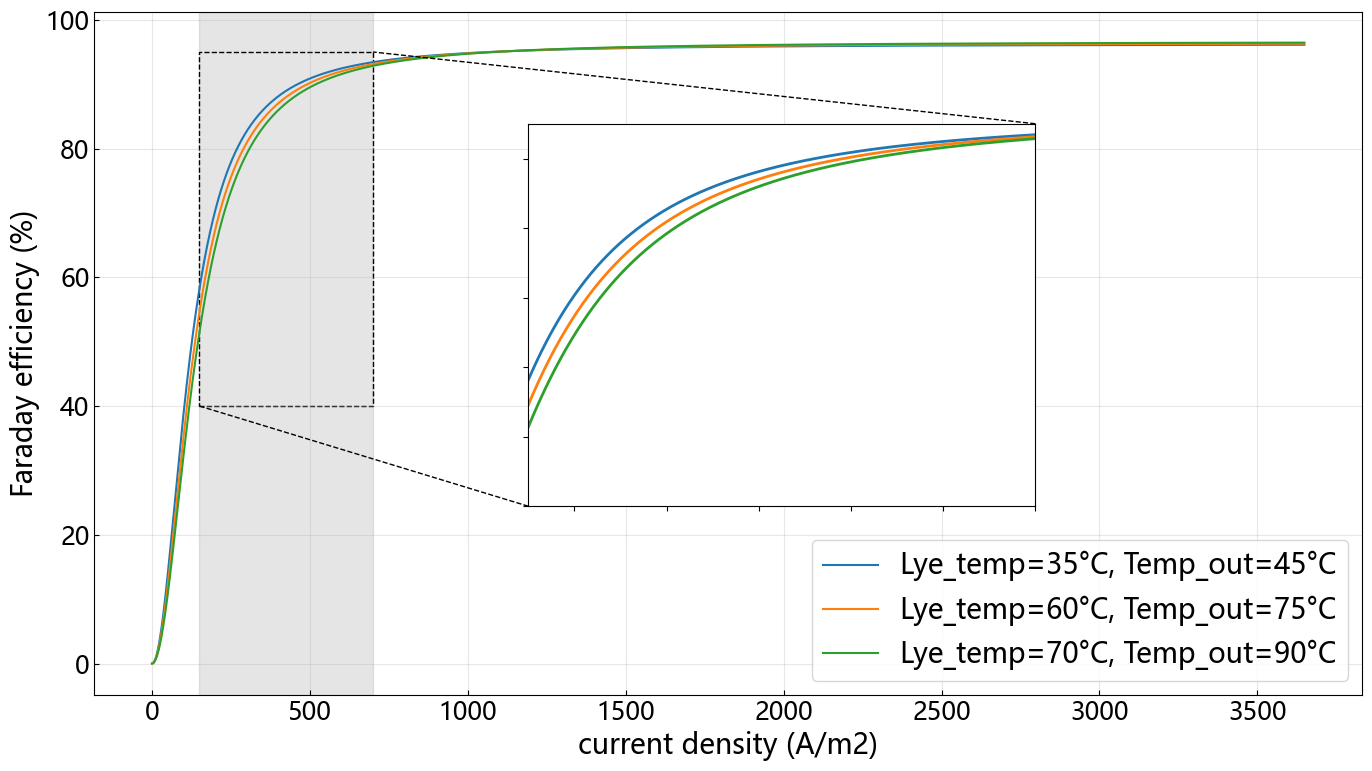

In [45]:
curdenarr=np.arange(0,3650)
fa40=[]
fa65=[]
fa90=[]
for cur in curdenarr:
    fa=AWE_Electrolyzer.Empirical_Faraday_efficiency_cal(Current_density=cur,
                                                         Temp_out=40,
                                                         Lye_temp=40)*100
    fa40.append(fa)
    fa=AWE_Electrolyzer.Empirical_Faraday_efficiency_cal(Current_density=cur,
                                                         Temp_out=65,
                                                         Lye_temp=65)*100
    fa65.append(fa)
    fa=AWE_Electrolyzer.Empirical_Faraday_efficiency_cal(Current_density=cur,
                                                         Temp_out=90,
                                                         Lye_temp=90)*100
    fa90.append(fa)

# 创建主图
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(fa40, label='Lye_temp=35°C, Temp_out=45°C')
ax.plot(fa65, label='Lye_temp=60°C, Temp_out=75°C')
ax.plot(fa90, label='Lye_temp=70°C, Temp_out=90°C')

plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')

# 定义需要放大的区域（x轴范围）
zoom_x_start, zoom_x_end = 150, 700  # 要放大的x范围
zoom_y_start, zoom_y_end = 40, 95  # 要放大的y范围

# 在主图中标记放大区域（可选）
ax.axvspan(zoom_x_start, zoom_x_end, color='gray', alpha=0.2)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# 创建内嵌子图（放大图）
ax_inset = inset_axes(
    ax, 
    width="80%",  # 放大图宽度（相对主图比例）
    height="80%", # 放大图高度（相对主图比例）
    bbox_to_anchor=(0.25, 0.15, 0.5, 0.7),  # 中间位置定位
    bbox_transform=ax.transAxes
)

# 在内嵌子图中绘制放大区域的数据
ax_inset.plot(fa40, linewidth=2)
ax_inset.plot(fa65, linewidth=2)
ax_inset.plot(fa90, linewidth=2)
ax_inset.set_xlim(zoom_x_start, zoom_x_end)  # 设置放大区域的x范围
ax_inset.set_ylim(zoom_y_start, zoom_y_end)  # 设置放大区域的y范围

# 添加连接线，标记主图与放大图的对应关系
mark_inset(ax, ax_inset, loc1=1, loc2=3, fc="none", ec="black", linestyle='--')

# 设置图表属性
ax.set_xlabel('current density (A/m2)', fontsize=20)
ax.set_ylabel('Faraday efficiency (%)', fontsize=20)
ax.legend(fontsize=20)
ax.grid(alpha=0.3)

# 隐藏内嵌图的刻度标签（可选，使图表更简洁）
ax_inset.set_xticklabels([])
ax_inset.set_yticklabels([])

plt.tight_layout()
plt.show()

## 画出极化曲线

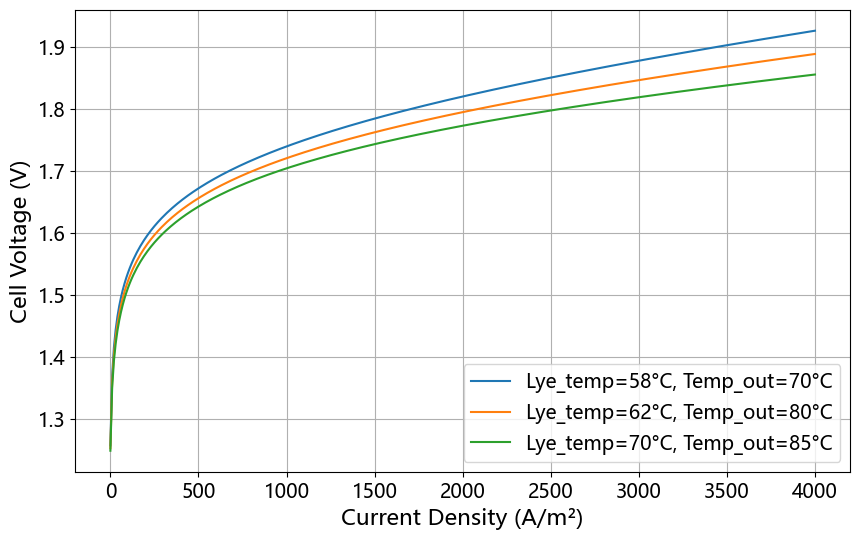

In [4]:
# 定义电流密度范围
current_densities = np.linspace(0, 4000, 400)

# 定义温度组合
temperature_combinations = [(58, 70), (62, 80), (70, 85)]

# 碱液流量和压力
Lye_flow = 0.45
Pressure = 1.6

# 初始化绘图
plt.figure(figsize=(10, 6))

# 遍历不同的温度组合
for Lye_temp, Temp_out in temperature_combinations:
    # 计算每个电流密度下的电池电压
    voltages = []
    for Current_density in current_densities:
        Vcell = AWE_Electrolyzer.Electrolytic_voltage_cal(Lye_temp, Temp_out, Current_density, Lye_flow, Pressure)
        voltages.append(Vcell)

    # 绘制极化曲线
    plt.plot(current_densities, voltages, label=f'Lye_temp={Lye_temp}°C, Temp_out={Temp_out}°C')

# 设置图表标题和标签
# plt.title('Polarization Curves at Different Temperature Combinations')
plt.xlabel('Current Density (A/m²)')
plt.ylabel('Cell Voltage (V)')
plt.legend()
plt.grid(True)

# 显示图表
plt.show()

## 画出3500电密,环境温度30度下不同出口温度、不同流量下入口温度map图

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# 创建网格数据
temp_out_array_3500 = np.linspace(70, 85, 100)  # 出口温度范围从60到85，间隔0.05度
lye_flow_array_3500 = np.linspace(0.3, 0.5, 100)  # 流量范围从0.3到0.5，间隔0.001m3/h
lye_temp_array_3500 = np.array([])  # 入口温度记录
V_cell_array_3500 = np.array([])  # 电压记录
Power_H_array_3500 = np.array([])  # 电耗记录
X, Y = np.meshgrid(temp_out_array_3500, lye_flow_array_3500)      # 创建二维网格

for lye_flow in lye_flow_array_3500:
    for temp_out in temp_out_array_3500:
        lye_temp  = AWE_Electrolyzer.Lye_temp_cal(Current_density = 3500,
                                   Temp_out = temp_out,
                                   Lye_flow = lye_flow,
                                   Temp_environment=0,
                                   Pressure = 1.6)  # 计算每个点的入口温度值
        lye_temp_array_3500 = np.append(lye_temp_array_3500, lye_temp)
        V_cell = AWE_Electrolyzer.Electrolytic_voltage_cal(Lye_temp = lye_temp,
                                                   Temp_out = temp_out,
                                                   Current_density = 3500,
                                                   Lye_flow = lye_flow,
                                                   Pressure=1.6)
        V_cell_array_3500 = np.append(V_cell_array_3500, V_cell)
        Power_H = AWE_Electrolyzer.Power_per_H_cal(Lye_temp=lye_temp,
                                                   Current_density=3500,
                                                   Temp_out=temp_out,
                                                   Pressure=1.6,
                                                   Lye_flow=lye_flow)
        Power_H_array_3500 = np.append(Power_H_array_3500, Power_H)


lye_temp_array_3500 = lye_temp_array_3500.reshape(len(lye_flow_array_3500), len(temp_out_array_3500))
V_cell_array_3500 = V_cell_array_3500.reshape(len(lye_flow_array_3500), len(temp_out_array_3500))
Power_H_array_3500 = Power_H_array_3500.reshape(len(lye_flow_array_3500), len(temp_out_array_3500))

In [11]:
V_cell_array_3500_reshape = V_cell_array_3500.T
Power_H_array_3500_reshape = Power_H_array_3500.T

# 不同出口温度下最小电耗
min_Power_H_array_3500_indices = np.argmin(Power_H_array_3500_reshape, axis=1)
# 不同出口温度下最小电耗对应的流量
min_Power_H_lye_flow_array_3500 = lye_flow_array_3500[min_Power_H_array_3500_indices]

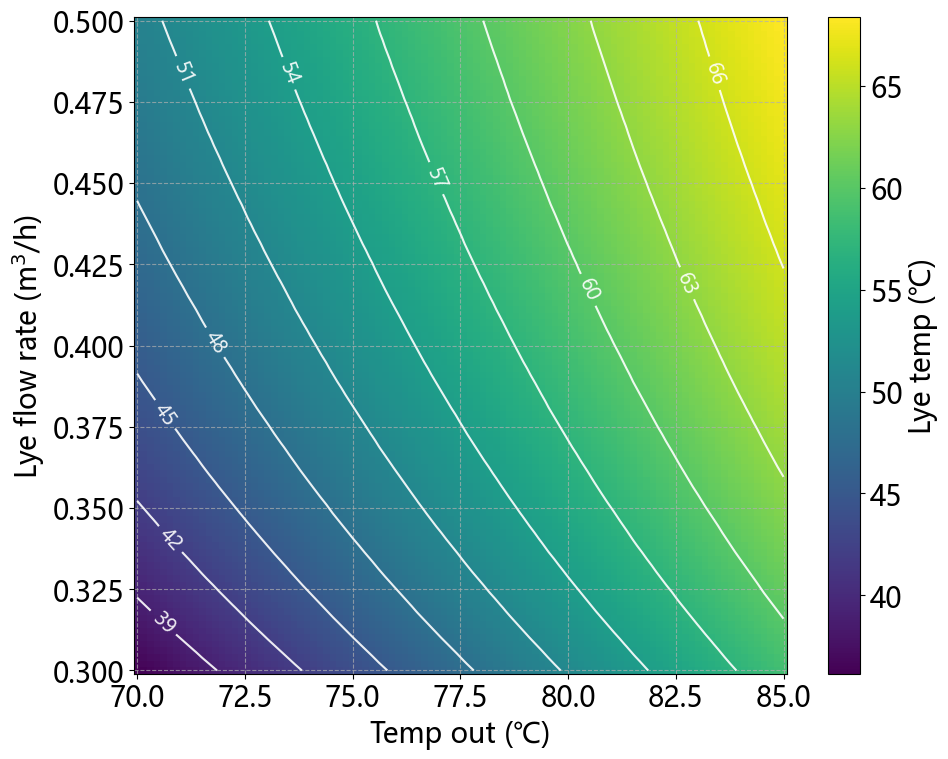

In [12]:
# 创建图形
plt.figure(figsize=(10, 8))

# 使用pcolormesh绘制z值的颜色图
plt.pcolormesh(X, Y, lye_temp_array_3500, shading='auto', cmap='viridis')

# 添加颜色条
plt.colorbar(label='Lye temp (℃)')

# 设置标题和坐标轴标签
# plt.title('3500电密下入口温度的颜色图', fontsize=15)
plt.xlabel('Temp out (℃)')
plt.ylabel('Lye flow rate (m$^3$/h)')

# 添加等高线，便于查看z值的分布
contour = plt.contour(X, Y, lye_temp_array_3500, 10, colors='white', alpha=0.9)
plt.clabel(contour, inline=True, fontsize=14)

# 显示网格线
plt.grid(True, linestyle='--', alpha=0.7)

# 显示图形
plt.tight_layout()
plt.show()

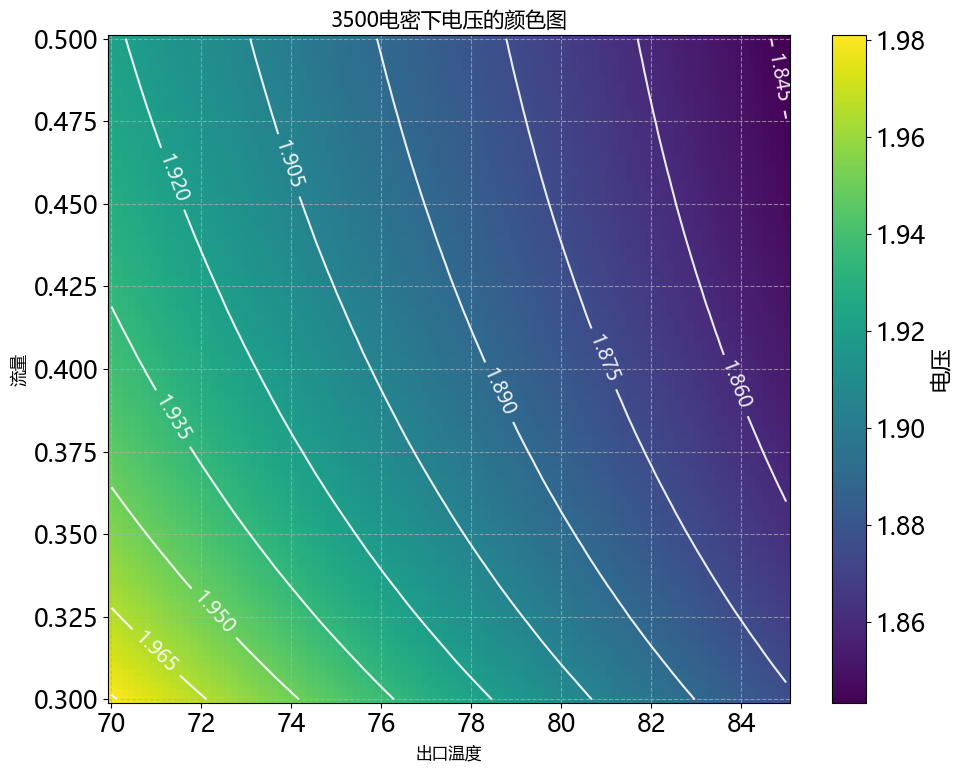

In [124]:
# 创建图形
plt.figure(figsize=(10, 8))

# 使用pcolormesh绘制z值的颜色图
plt.pcolormesh(X, Y, V_cell_array_3500, shading='auto', cmap='viridis')

# 添加颜色条
plt.colorbar(label='电压')

# 设置标题和坐标轴标签
plt.title('3500电密下电压的颜色图', fontsize=15)
plt.xlabel('出口温度', fontsize=12)
plt.ylabel('流量', fontsize=12)

# 添加等高线，便于查看z值的分布
contour = plt.contour(X, Y, V_cell_array_3500, 10, colors='white', alpha=0.9)
plt.clabel(contour, inline=True, fontsize=14)

# 显示网格线
plt.grid(True, linestyle='--', alpha=0.7)

# 显示图形
plt.tight_layout()
plt.show()

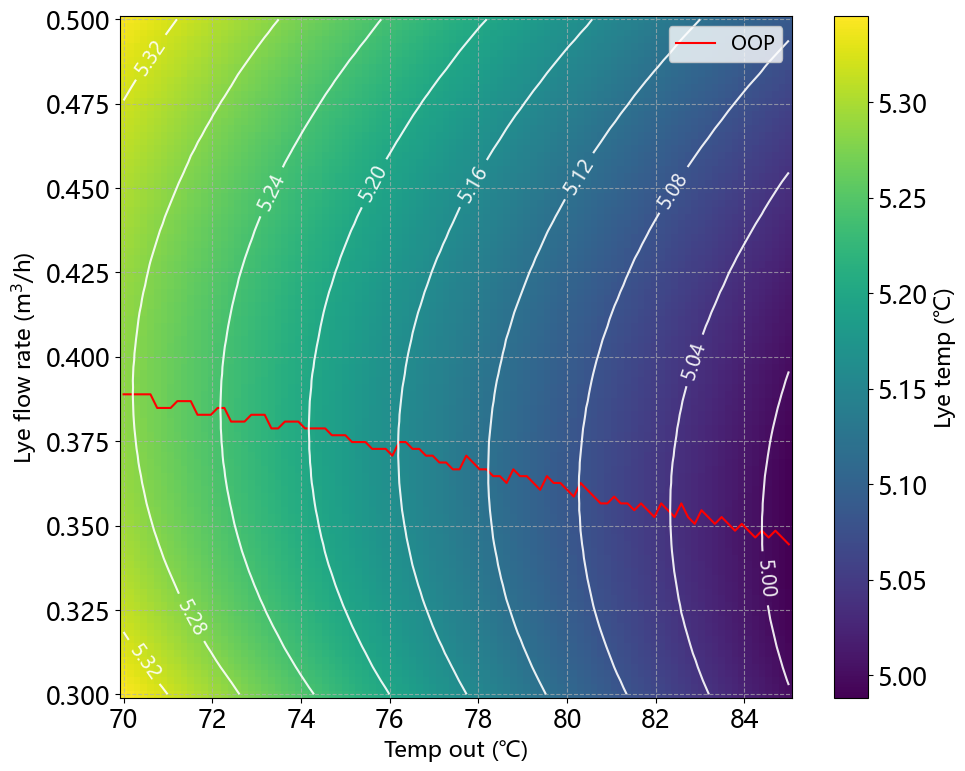

In [125]:
# 创建图形
plt.figure(figsize=(10, 8))

plt.plot(temp_out_array_3500, min_Power_H_lye_flow_array_3500, c='r', label='OOP')
plt.legend()

# 使用pcolormesh绘制z值的颜色图
plt.pcolormesh(X, Y, Power_H_array_3500, shading='auto', cmap='viridis')

# 添加颜色条
plt.colorbar(label='Lye temp (℃)')

# 设置标题和坐标轴标签
# plt.title('3500电密下入口温度的颜色图', fontsize=15)
plt.xlabel('Temp out (℃)')
plt.ylabel('Lye flow rate (m$^3$/h)')

# 添加等高线，便于查看z值的分布
contour = plt.contour(X, Y, Power_H_array_3500, 10, colors='white', alpha=0.9)
plt.clabel(contour, inline=True, fontsize=14)

# 显示网格线
plt.grid(True, linestyle='--', alpha=0.7)

# 显示图形
plt.tight_layout()
plt.show()

## 画出3000电密下不同出口温度、不同流量下入口温度map图

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# 创建网格数据
temp_out_array_3000 = np.linspace(70, 85, 100)  # 出口温度范围从60到85，间隔0.05度
lye_flow_array_3000 = np.linspace(0.3, 0.5, 100)  # 流量范围从0.3到0.5，间隔0.001m3/h
lye_temp_array_3000 = np.array([])  # 入口温度记录
V_cell_array_3000 = np.array([])  # 电压记录
Power_H_array_3000 = np.array([])  # 电耗记录
X, Y = np.meshgrid(temp_out_array_3000, lye_flow_array_3000)      # 创建二维网格

for lye_flow in lye_flow_array_3000:
    for temp_out in temp_out_array_3000:
        lye_temp  = AWE_Electrolyzer.Lye_temp_cal(Current_density = 3000,
                                   Temp_out = temp_out,
                                   Lye_flow = lye_flow,
                                   Temp_environment=0,
                                   Pressure = 1.6)  # 计算每个点的入口温度值
        lye_temp_array_3000 = np.append(lye_temp_array_3000, lye_temp)
        V_cell = AWE_Electrolyzer.Electrolytic_voltage_cal(Lye_temp = lye_temp,
                                                   Temp_out = temp_out,
                                                   Current_density = 3000,
                                                   Lye_flow = lye_flow,
                                                   Pressure=1.6)
        V_cell_array_3000 = np.append(V_cell_array_3000, V_cell)
        Power_H = AWE_Electrolyzer.Power_per_H_cal(Lye_temp=lye_temp,
                                                   Current_density=3000,
                                                   Temp_out=temp_out,
                                                   Pressure=1.6,
                                                   Lye_flow=lye_flow)
        Power_H_array_3000 = np.append(Power_H_array_3000, Power_H)


lye_temp_array_3000 = lye_temp_array_3000.reshape(len(lye_flow_array_3000), len(temp_out_array_3000))
V_cell_array_3000 = V_cell_array_3000.reshape(len(lye_flow_array_3000), len(temp_out_array_3000))
Power_H_array_3000 = Power_H_array_3000.reshape(len(lye_flow_array_3000), len(temp_out_array_3000))

In [5]:
V_cell_array_3000_reshape = V_cell_array_3000.T
Power_H_array_3000_reshape = Power_H_array_3000.T

# 不同出口温度下最小电耗
min_Power_H_array_3000_indices = np.argmin(Power_H_array_3000_reshape, axis=1)
# 不同出口温度下最小电耗对应的流量
min_Power_H_lye_flow_array_3000 = lye_flow_array_3000[min_Power_H_array_3000_indices]

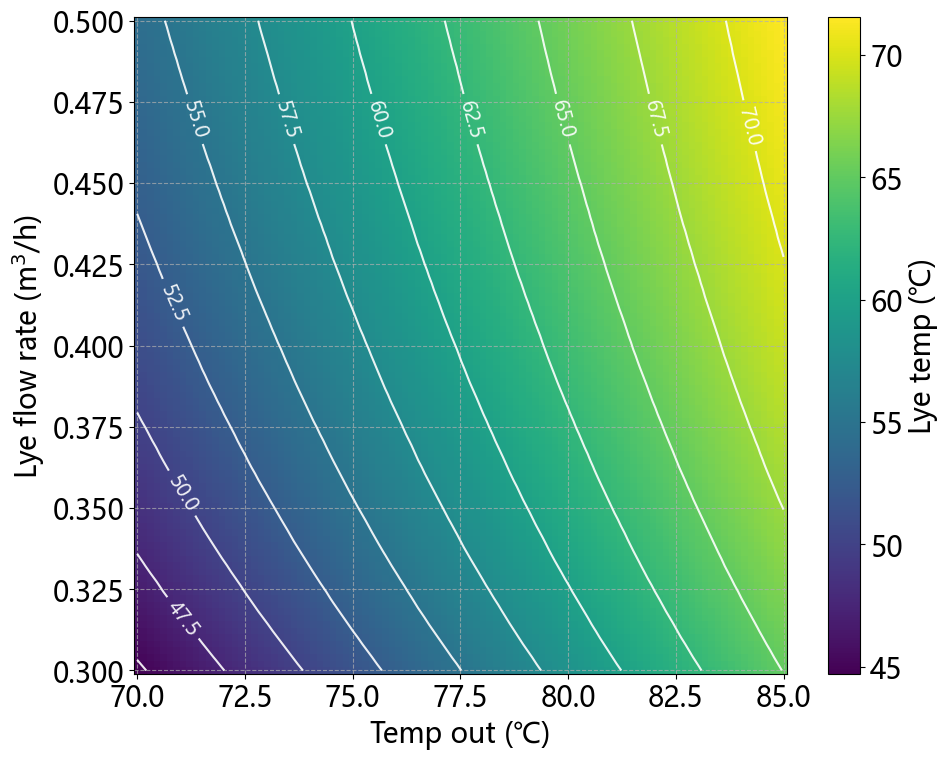

In [19]:
# 创建图形
plt.figure(figsize=(10, 8))

# 使用pcolormesh绘制z值的颜色图
plt.pcolormesh(X, Y, lye_temp_array_3000, shading='auto', cmap='viridis')

# 添加颜色条
plt.colorbar(label='Lye temp (℃)')

# 设置标题和坐标轴标签
# plt.title('3000电密下入口温度的颜色图', fontsize=15)
plt.xlabel('Temp out (℃)')
plt.ylabel('Lye flow rate (m$^3$/h)')

# 添加等高线，便于查看z值的分布
contour = plt.contour(X, Y, lye_temp_array_3000, 10, colors='white', alpha=0.9)
plt.clabel(contour, inline=True, fontsize=14)

# 显示网格线
plt.grid(True, linestyle='--', alpha=0.7)

# 显示图形
plt.tight_layout()
plt.show()

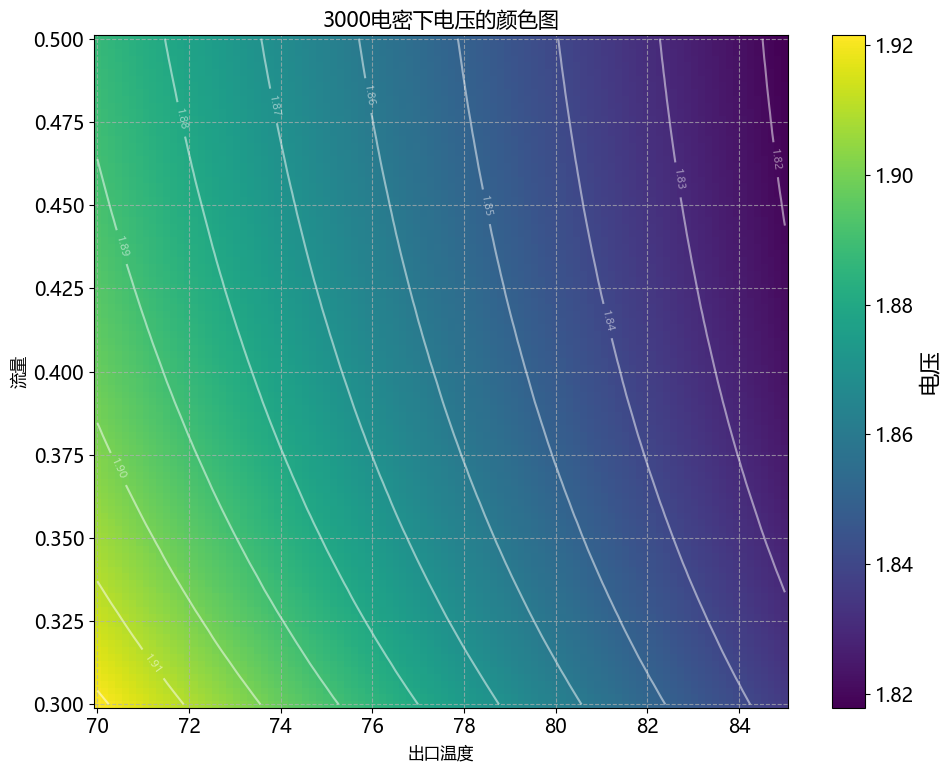

In [7]:
# 创建图形
plt.figure(figsize=(10, 8))

# 使用pcolormesh绘制z值的颜色图
plt.pcolormesh(X, Y, V_cell_array_3000, shading='auto', cmap='viridis')

# 添加颜色条
plt.colorbar(label='电压')

# 设置标题和坐标轴标签
plt.title('3000电密下电压的颜色图', fontsize=15)
plt.xlabel('出口温度', fontsize=12)
plt.ylabel('流量', fontsize=12)

# 添加等高线，便于查看z值的分布
contour = plt.contour(X, Y, V_cell_array_3000, 10, colors='white', alpha=0.5)
plt.clabel(contour, inline=True, fontsize=8)

# 显示网格线
plt.grid(True, linestyle='--', alpha=0.7)

# 显示图形
plt.tight_layout()
plt.show()

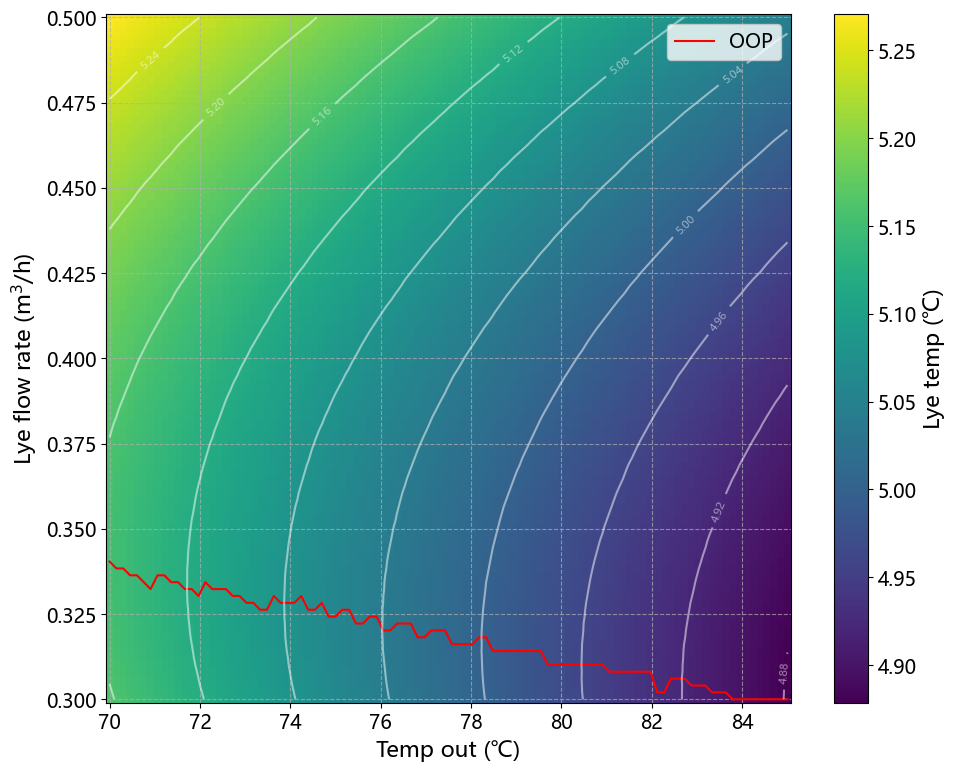

In [8]:
# 创建图形
plt.figure(figsize=(10, 8))

plt.plot(temp_out_array_3000, min_Power_H_lye_flow_array_3000, c='r', label='OOP')
plt.legend()

# 使用pcolormesh绘制z值的颜色图
plt.pcolormesh(X, Y, Power_H_array_3000, shading='auto', cmap='viridis')

# 添加颜色条
plt.colorbar(label='Lye temp (℃)')

# 设置标题和坐标轴标签
# plt.title('3500电密下入口温度的颜色图', fontsize=15)
plt.xlabel('Temp out (℃)')
plt.ylabel('Lye flow rate (m$^3$/h)')

# 添加等高线，便于查看z值的分布
contour = plt.contour(X, Y, Power_H_array_3000, 10, colors='white', alpha=0.5)
plt.clabel(contour, inline=True, fontsize=8)

# 显示网格线
plt.grid(True, linestyle='--', alpha=0.7)

# 显示图形
plt.tight_layout()
plt.show()

## 画出2500电密下不同出口温度、不同流量下入口温度map图

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 创建网格数据
temp_out_array_2500 = np.linspace(70, 85, 100)  # 出口温度范围从60到85，间隔0.05度
lye_flow_array_2500 = np.linspace(0.3, 0.5, 100)  # 流量范围从0.3到0.5，间隔0.001m3/h
lye_temp_array_2500 = np.array([])  # 入口温度记录
V_cell_array_2500 = np.array([])  # 电压记录
Power_H_array_2500 = np.array([])  # 电耗记录
X, Y = np.meshgrid(temp_out_array_2500, lye_flow_array_2500)      # 创建二维网格

for lye_flow in lye_flow_array_2500:
    for temp_out in temp_out_array_2500:
        lye_temp  = AWE_Electrolyzer.Lye_temp_cal(Current_density = 2500,
                                   Temp_out = temp_out,
                                   Lye_flow = lye_flow,
                                   Temp_environment=20,
                                   Pressure = 1.6)  # 计算每个点的入口温度值
        lye_temp_array_2500 = np.append(lye_temp_array_2500, lye_temp)
        V_cell = AWE_Electrolyzer.Electrolytic_voltage_cal(Lye_temp = lye_temp,
                                                   Temp_out = temp_out,
                                                   Current_density = 2500,
                                                   Lye_flow = lye_flow,
                                                   Pressure=1.6)
        V_cell_array_2500 = np.append(V_cell_array_2500, V_cell)
        Power_H = AWE_Electrolyzer.Power_per_H_cal(Lye_temp=lye_temp,
                                                   Current_density=2500,
                                                   Temp_out=temp_out,
                                                   Pressure=1.6,
                                                   Lye_flow=lye_flow)
        Power_H_array_2500 = np.append(Power_H_array_2500, Power_H)


lye_temp_array_2500 = lye_temp_array_2500.reshape(len(lye_flow_array_2500), len(temp_out_array_2500))
V_cell_array_2500 = V_cell_array_2500.reshape(len(lye_flow_array_2500), len(temp_out_array_2500))
Power_H_array_2500 = Power_H_array_2500.reshape(len(lye_flow_array_2500), len(temp_out_array_2500))

In [ ]:
V_cell_array_2500_reshape = V_cell_array_2500.T
Power_H_array_2500_reshape = Power_H_array_2500.T

# 不同出口温度下最小电耗
min_Power_H_array_2500_indices = np.argmin(Power_H_array_2500_reshape, axis=1)
# 不同出口温度下最小电耗对应的流量
min_Power_H_lye_flow_array_2500 = lye_flow_array_2500[min_Power_H_array_2500_indices]

In [ ]:
# 创建图形
plt.figure(figsize=(10, 8))

# 使用pcolormesh绘制z值的颜色图
plt.pcolormesh(X, Y, lye_temp_array_2500, shading='auto', cmap='viridis')

# 添加颜色条
plt.colorbar(label='入口温度')

# 设置标题和坐标轴标签
plt.title('2500电密下入口温度的颜色图', fontsize=15)
plt.xlabel('出口温度', fontsize=12)
plt.ylabel('流量', fontsize=12)

# 添加等高线，便于查看z值的分布
contour = plt.contour(X, Y, lye_temp_array_2500, 10, colors='white', alpha=0.5)
plt.clabel(contour, inline=True, fontsize=8)

# 显示网格线
plt.grid(True, linestyle='--', alpha=0.7)

# 显示图形
plt.tight_layout()
plt.show()

In [ ]:
# 创建图形
plt.figure(figsize=(10, 8))

# 使用pcolormesh绘制z值的颜色图
plt.pcolormesh(X, Y, V_cell_array_2500, shading='auto', cmap='viridis')

# 添加颜色条
plt.colorbar(label='电压')

# 设置标题和坐标轴标签
plt.title('2500电密下电压的颜色图', fontsize=15)
plt.xlabel('出口温度', fontsize=12)
plt.ylabel('流量', fontsize=12)

# 添加等高线，便于查看z值的分布
contour = plt.contour(X, Y, V_cell_array_2500, 10, colors='white', alpha=0.5)
plt.clabel(contour, inline=True, fontsize=8)

# 显示网格线
plt.grid(True, linestyle='--', alpha=0.7)

# 显示图形
plt.tight_layout()
plt.show()

In [ ]:
# 创建图形
plt.figure(figsize=(10, 8))

plt.plot(temp_out_array_2500, min_Power_H_lye_flow_array_2500, c='r', label='最优工况点对应流量')
plt.legend()

# 使用pcolormesh绘制z值的颜色图
plt.pcolormesh(X, Y, Power_H_array_2500, shading='auto', cmap='viridis')

# 添加颜色条
plt.colorbar(label='入口温度')

# 设置标题和坐标轴标签
plt.title('2500电密下单位产氢电耗的颜色图', fontsize=15)
plt.xlabel('出口温度', fontsize=12)
plt.ylabel('流量', fontsize=12)

# 添加等高线，便于查看z值的分布
contour = plt.contour(X, Y, Power_H_array_2500, 10, colors='white', alpha=0.5)
plt.clabel(contour, inline=True, fontsize=8)

# 显示网格线
plt.grid(True, linestyle='--', alpha=0.7)

# 显示图形
plt.tight_layout()
plt.show()

## 画出2000电密下不同出口温度、不同流量下入口温度map图

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 创建网格数据
temp_out_array_2000 = np.linspace(70, 85, 100)  # 出口温度范围从60到85，间隔0.05度
lye_flow_array_2000 = np.linspace(0.3, 0.5, 100)  # 流量范围从0.3到0.5，间隔0.001m3/h
lye_temp_array_2000 = np.array([])  # 入口温度记录
V_cell_array_2000 = np.array([])  # 电压记录
Power_H_array_2000 = np.array([])  # 电耗记录
X, Y = np.meshgrid(temp_out_array_2000, lye_flow_array_2000)      # 创建二维网格

for lye_flow in lye_flow_array_2000:
    for temp_out in temp_out_array_2000:
        lye_temp  = AWE_Electrolyzer.Lye_temp_cal(Current_density = 2000,
                                   Temp_out = temp_out,
                                   Lye_flow = lye_flow,
                                   Temp_environment=20,
                                   Pressure = 1.6)  # 计算每个点的入口温度值
        lye_temp_array_2000 = np.append(lye_temp_array_2000, lye_temp)
        V_cell = AWE_Electrolyzer.Electrolytic_voltage_cal(Lye_temp = lye_temp,
                                                   Temp_out = temp_out,
                                                   Current_density = 2000,
                                                   Lye_flow = lye_flow,
                                                   Pressure=1.6)
        V_cell_array_2000 = np.append(V_cell_array_2000, V_cell)
        Power_H = AWE_Electrolyzer.Power_per_H_cal(Lye_temp=lye_temp,
                                                   Current_density=2000,
                                                   Temp_out=temp_out,
                                                   Pressure=1.6,
                                                   Lye_flow=lye_flow)
        Power_H_array_2000 = np.append(Power_H_array_2000, Power_H)


lye_temp_array_2000 = lye_temp_array_2000.reshape(len(lye_flow_array_2000), len(temp_out_array_2000))
V_cell_array_2000 = V_cell_array_2000.reshape(len(lye_flow_array_2000), len(temp_out_array_2000))
Power_H_array_2000 = Power_H_array_2000.reshape(len(lye_flow_array_2000), len(temp_out_array_2000))

In [ ]:
V_cell_array_2000_reshape = V_cell_array_2000.T
Power_H_array_2000_reshape = Power_H_array_2000.T

# 不同出口温度下最小电耗
min_Power_H_array_2000_indices = np.argmin(Power_H_array_2000_reshape, axis=1)
# 不同出口温度下最小电耗对应的流量
min_Power_H_lye_flow_array_2000 = lye_flow_array_2000[min_Power_H_array_2000_indices]

In [ ]:
# 创建图形
plt.figure(figsize=(10, 8))

# 使用pcolormesh绘制z值的颜色图
plt.pcolormesh(X, Y, lye_temp_array_2000, shading='auto', cmap='viridis')

# 添加颜色条
plt.colorbar(label='入口温度')

# 设置标题和坐标轴标签
plt.title('2000电密下入口温度的颜色图', fontsize=15)
plt.xlabel('出口温度', fontsize=12)
plt.ylabel('流量', fontsize=12)

# 添加等高线，便于查看z值的分布
contour = plt.contour(X, Y, lye_temp_array_2000, 10, colors='white', alpha=0.5)
plt.clabel(contour, inline=True, fontsize=8)

# 显示网格线
plt.grid(True, linestyle='--', alpha=0.7)

# 显示图形
plt.tight_layout()
plt.show()

In [ ]:
# 创建图形
plt.figure(figsize=(10, 8))

# 使用pcolormesh绘制z值的颜色图
plt.pcolormesh(X, Y, V_cell_array_2000, shading='auto', cmap='viridis')

# 添加颜色条
plt.colorbar(label='电压')

# 设置标题和坐标轴标签
plt.title('2000电密下电压的颜色图', fontsize=15)
plt.xlabel('出口温度', fontsize=12)
plt.ylabel('流量', fontsize=12)

# 添加等高线，便于查看z值的分布
contour = plt.contour(X, Y, V_cell_array_2000, 10, colors='white', alpha=0.5)
plt.clabel(contour, inline=True, fontsize=8)

# 显示网格线
plt.grid(True, linestyle='--', alpha=0.7)

# 显示图形
plt.tight_layout()
plt.show()

In [ ]:
# 创建图形
plt.figure(figsize=(10, 8))

plt.plot(temp_out_array_2000, min_Power_H_lye_flow_array_2000, c='r', label='最优工况点对应流量')
plt.legend()

# 使用pcolormesh绘制z值的颜色图
plt.pcolormesh(X, Y, Power_H_array_2000, shading='auto', cmap='viridis')

# 添加颜色条
plt.colorbar(label='入口温度')

# 设置标题和坐标轴标签
plt.title('2000电密下单位产氢电耗的颜色图', fontsize=15)
plt.xlabel('出口温度', fontsize=12)
plt.ylabel('流量', fontsize=12)

# 添加等高线，便于查看z值的分布
contour = plt.contour(X, Y, Power_H_array_2000, 10, colors='white', alpha=0.5)
plt.clabel(contour, inline=True, fontsize=8)

# 显示网格线
plt.grid(True, linestyle='--', alpha=0.7)

# 显示图形
plt.tight_layout()
plt.show()

## 画出出口温度85度3500、3000、2500、2000电密下不同碱液流量对应的功耗变化（横坐标流量，纵坐标不同种类功耗）

In [46]:
current_density_array_sep = np.array([3500, 3000, 2500, 2000])
lye_flow_array_sep = np.arange(0.3, 0.51, 0.01)
power_lye_pump_list = [[], [], [], []]
power_cooling_list = [[], [], [], []]
power_electrolysis_list = [[], [], [], []]
power_H_list = [[], [], [], []]


for current_density in current_density_array_sep:
    index = np.where(current_density_array_sep == current_density)[0][0]
    for lye_flow in lye_flow_array_sep:

        power_lye_pump = AWE_Electrolyzer.Power_Lye_Pump_cal(Lye_flow=lye_flow)
        power_lye_pump_list[index].append(power_lye_pump)


        lye_temp  = AWE_Electrolyzer.Lye_temp_cal(Current_density = current_density,
                                   Temp_out = 85,
                                   Lye_flow = lye_flow,
                                   Temp_environment=20,
                                   Pressure = 1.6)  # 计算每个点的入口温度值
        power_cooling = AWE_Electrolyzer.Power_Cooling_cal(Lye_flow = lye_flow,
                                          Temp_out = 85,
                                          Lye_temp = lye_temp) * 0.3 # 冷却功率 W
        power_cooling_list[index].append(power_cooling)
        
        V_cell = AWE_Electrolyzer.Electrolytic_voltage_cal(Lye_temp = lye_temp,
                                                   Temp_out = 85,
                                                   Current_density = current_density,
                                                   Lye_flow = lye_flow,
                                                   Pressure=1.6)
        power_electrolysis = current_density * V_cell * AWE_Electrolyzer.Area_Electrode * AWE_Electrolyzer.Num_Cells
        power_electrolysis_list[index].append(power_electrolysis)

        power_H = AWE_Electrolyzer.Power_per_H_cal(Lye_temp=lye_temp,
                                                   Current_density=current_density,
                                                   Temp_out=85,
                                                   Pressure=1.6,
                                                   Lye_flow=lye_flow)
        power_H_list[index].append(power_H)

In [47]:
print(min(power_cooling_list[0]))

3144.930866666667


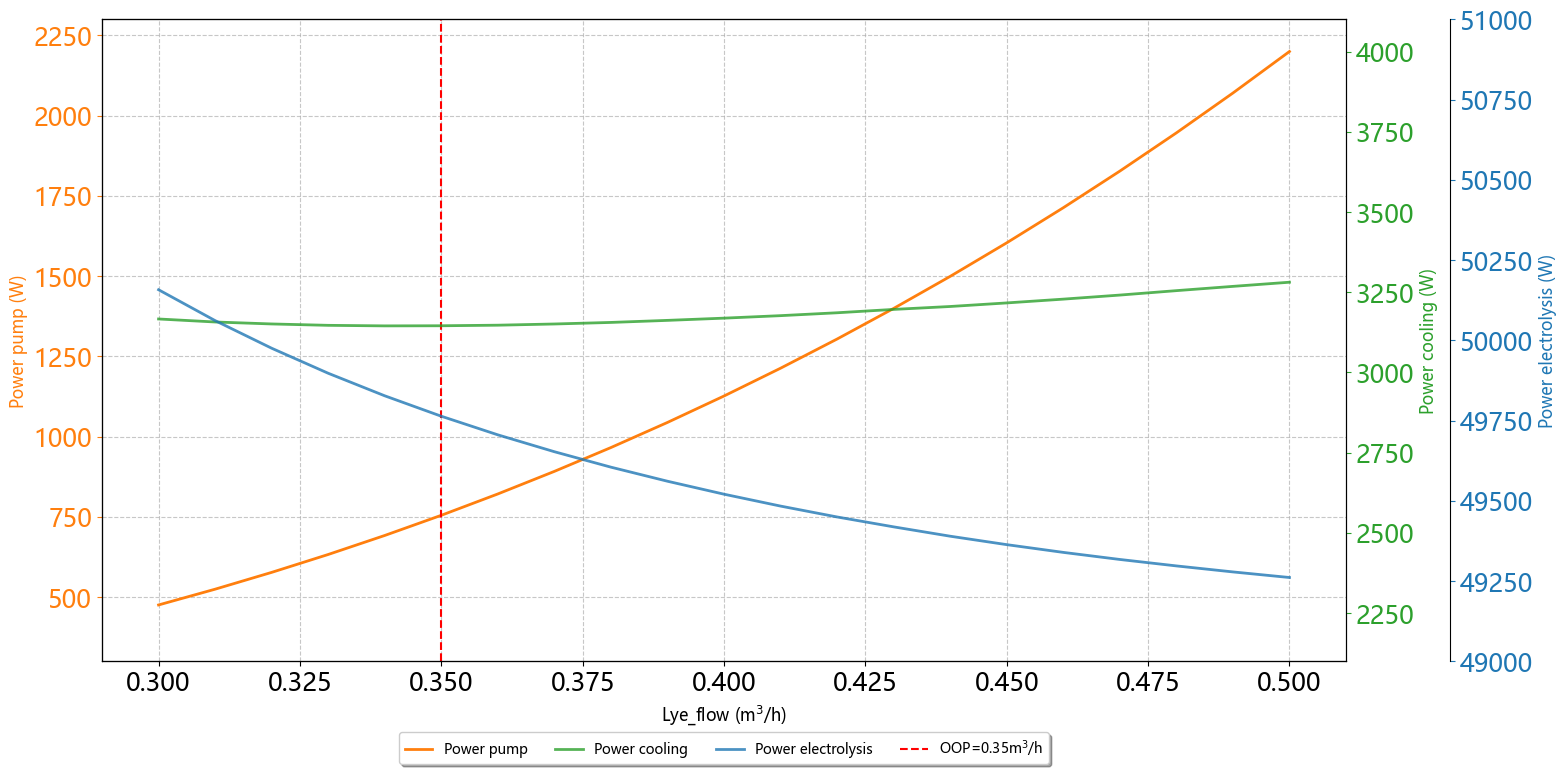

In [73]:
min_power_H_3500 = np.argmin(power_H_list[0])
lye_flow_at_min_power_H_3500 = lye_flow_array_sep[min_power_H_3500]

# 创建图表
fig, ax1 = plt.subplots(figsize=(16, 8))
# plt.title('3500电密出口85度碱液流量对功耗的影响', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)

# 绘制第一个因变量: 碱泵功耗
line1, = ax1.plot(lye_flow_array_sep, power_lye_pump_list[0], 
                 c='#ff7f0e', linewidth=2.0, label='Power pump')
ax1.set_xlabel('Lye_flow (m$^3$/h)', fontsize=12)
ax1.set_ylabel('Power pump (W)', color='#ff7f0e', fontsize=12)
ax1.set_ylim(300, 2300)
ax1.tick_params(axis='y', colors='#ff7f0e')

# 创建第二个y轴: 冷却功耗
ax2 = ax1.twinx()
line2, = ax2.plot(lye_flow_array_sep, power_cooling_list[0], 
                 alpha=0.8, c='#2ca02c', linewidth=2.0, label='Power cooling')
ax2.set_ylabel('Power cooling (W)', color='#2ca02c', fontsize=12)
ax2.tick_params(axis='y', colors='#2ca02c')
ax2.set_ylim(2100, 4100)

# 创建第三个y轴: 电解功耗
ax3 = ax1.twinx()
line3, = ax3.plot(lye_flow_array_sep, power_electrolysis_list[0], 
                 c='#1f77b4', alpha=0.8, linewidth=2.0, label='Power electrolysis')
ax3.set_ylabel('Power electrolysis (W)', color='#1f77b4', fontsize=12)
ax3.spines['right'].set_position(('outward', 75))
ax3.tick_params(axis='y', colors='#1f77b4')
ax3.set_ylim(49000, 51000)

# 绘制单位产氢能耗最低时对应的碱液流量垂直线
min_line = ax1.axvline(x=lye_flow_at_min_power_H_3500, 
                     color='red', linestyle='--', linewidth=1.5,
                     label=f'OOP={lye_flow_at_min_power_H_3500:.2f}m$^3$/h')


# 优化图例显示 - 合并所有线条和标签
lines = [line1, line2, line3, min_line]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1),
          ncol=5, fontsize=10, frameon=True, fancybox=True, shadow=True)

# 优化布局
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # 为右侧多个y轴腾出空间

# 显示图表
plt.show()

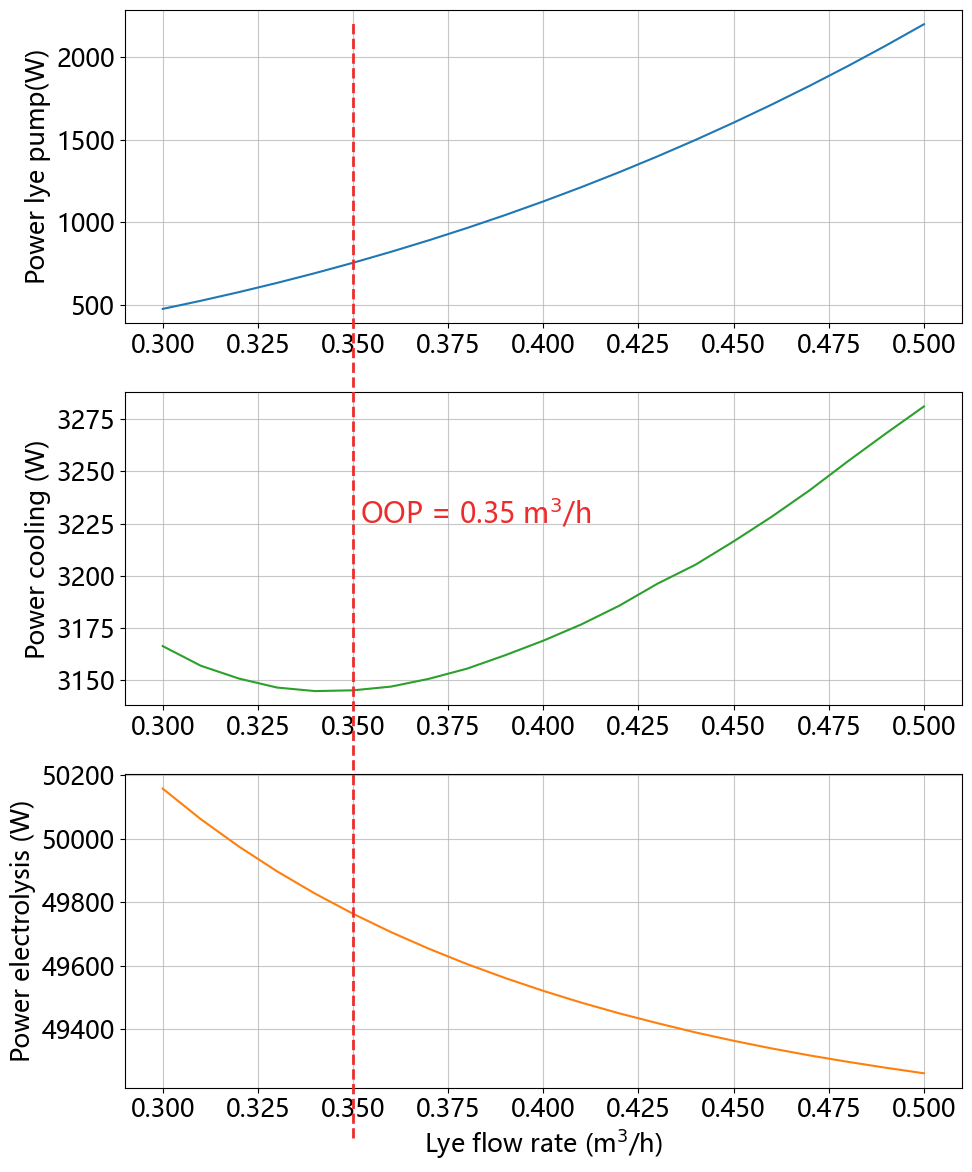

In [114]:
# 创建3行1列的子图布局（fig为画布，axes为子图数组）
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))  # 高度设大些，避免拥挤

# 第一张图（第1行）
axes[0].plot(lye_flow_array_sep, power_lye_pump_list[0], color='#1f77b4')
# axes[0].set_xlabel('Lye flow rate (m$^3$/h)', fontsize=18)
axes[0].set_ylabel('Power lye pump(W)', fontsize=18)
axes[0].grid(alpha=0.7)

# 第二张图（第2行）
axes[1].plot(lye_flow_array_sep, power_cooling_list[0], color='#2ca02c')
# axes[1].set_xlabel('Lye flow rate (m$^3$/h)', fontsize=18)
axes[1].set_ylabel('Power cooling (W)', fontsize=18)
axes[1].grid(alpha=0.7)

# 第三张图（第3行）
axes[2].plot(lye_flow_array_sep, power_electrolysis_list[0], color='#ff7f0e')
axes[2].set_xlabel('Lye flow rate (m$^3$/h)', fontsize=18)
axes[2].set_ylabel('Power electrolysis (W)', fontsize=18)
axes[2].grid(alpha=0.7)

# 定义贯穿线的x坐标
x_pos = 0.3708

# 在画布层面添加贯穿所有子图的竖直线
# 转换x坐标为画布的相对坐标（0-1范围）
x_data = x_pos
x_min, x_max = axes[0].get_xlim()  # 获取x轴范围
x_fig = (x_data - x_min) / (x_max - x_min)  # 转换为相对坐标

from matplotlib.lines import Line2D

# 创建直线对象（从画布顶部到底部）
line = Line2D(
    [x_fig, x_fig],  # x坐标（画布相对坐标，0-1）
    [0.04, 0.97],          # y坐标（0为底部，1为顶部，实现贯穿）
    transform=fig.transFigure,  # 使用画布坐标系统
    color = "#ed2d2d",
    linestyle='--',
    linewidth=2,
    zorder=10  # 确保线条在子图上方显示
)

# 添加直线到画布
fig.add_artist(line)

fig.text(0.49, 0.56, 'OOP = 0.35 m$^3$/h', va='center', ha='center', color = '#ed2d2d', fontsize=20)

# 调整子图间距（避免标题和标签重叠）
plt.tight_layout()  # 自动调整布局

plt.show()

## 3500电密下功耗堆积柱状图

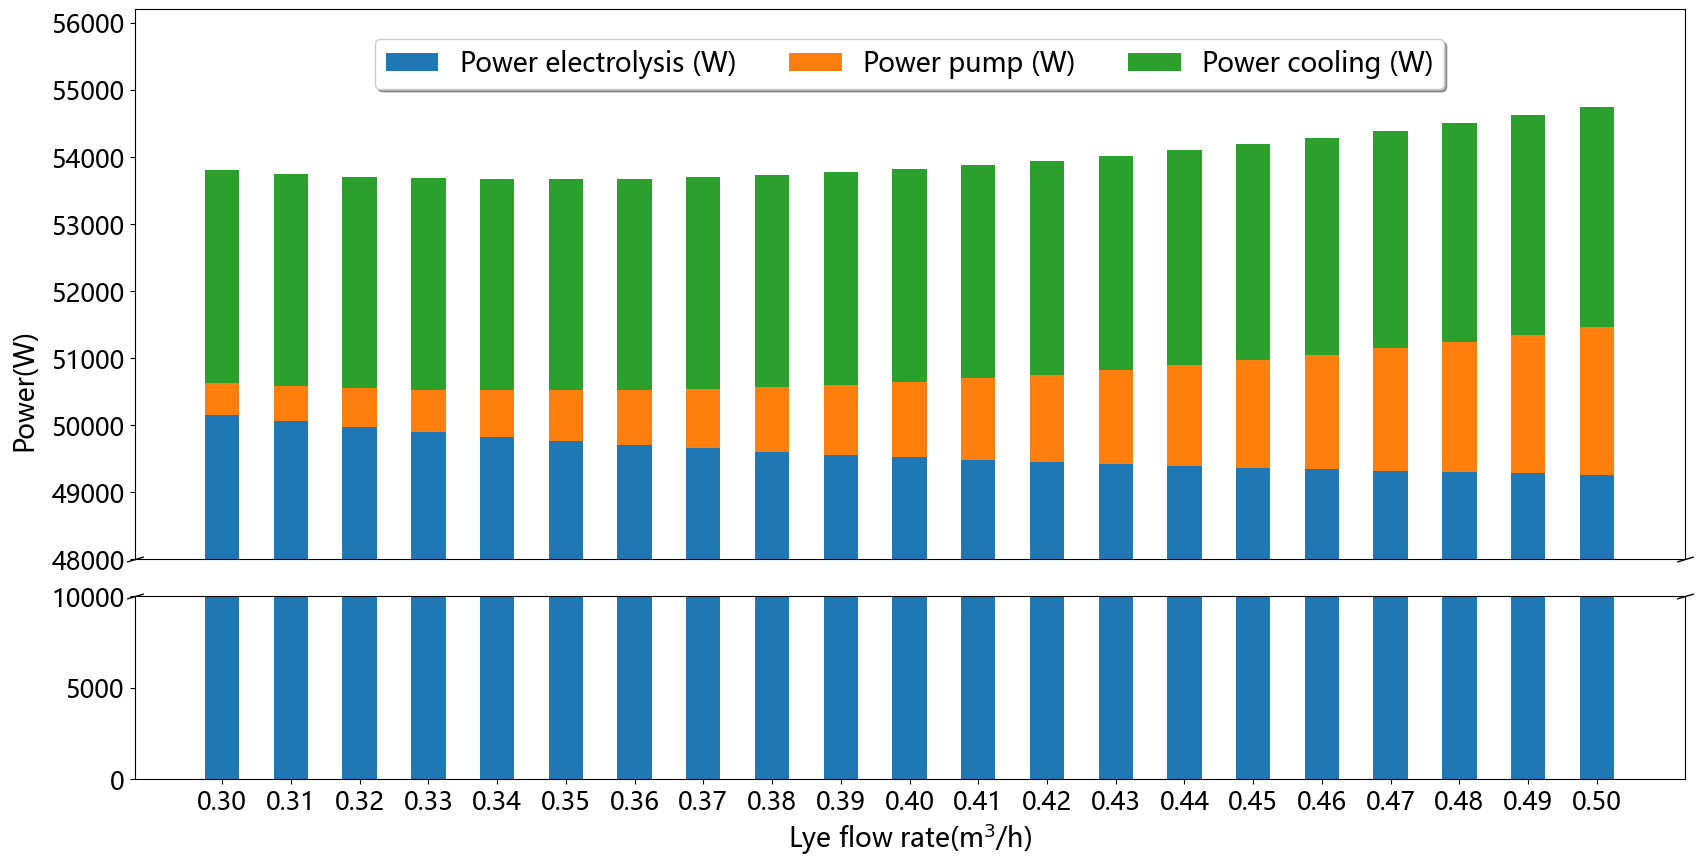

In [120]:
power_lye_pump_array = np.array(power_lye_pump_list[0])
power_cooling_array = np.array(power_cooling_list[0])
power_electrolysis_array = np.array(power_electrolysis_list[0])
power_H_array = np.array(power_H_list[0])

# 创建两个子图，共享x轴
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20, 10), gridspec_kw={'height_ratios': [3, 1]})
fig.subplots_adjust(hspace=0.1)  # 减少子图之间的间距

# 绘制上半部分（高值区域）
bottom1 = np.zeros(len(lye_flow_array_sep))
ax1.bar(lye_flow_array_sep, power_electrolysis_array, width=0.005, label='Power electrolysis (W)', bottom=bottom1)
bottom1 += np.array(power_electrolysis_array)
ax1.bar(lye_flow_array_sep, power_lye_pump_array, width=0.005, label='Power pump (W)', bottom=bottom1)
bottom1 += np.array(power_lye_pump_array)
ax1.bar(lye_flow_array_sep, power_cooling_array, width=0.005, label='Power cooling (W)', bottom=bottom1)

# 绘制下半部分（低值区域）
bottom2 = np.zeros(len(lye_flow_array_sep))
ax2.bar(lye_flow_array_sep, power_electrolysis_array, width=0.005, label='Power electrolysis', bottom=bottom2)
bottom2 += np.array(power_electrolysis_array)
ax2.bar(lye_flow_array_sep, power_lye_pump_array, width=0.005, label='Power pump', bottom=bottom2)
bottom2 += np.array(power_lye_pump_array)
ax2.bar(lye_flow_array_sep, power_cooling_array, width=0.005, label='冷却功耗', bottom=bottom2)

# 设置y轴范围
ax1.set_ylim(48000, 56200)  # 上半部分显示150-250
ax2.set_ylim(0, 10000)    # 下半部分显示0-100

# 添加断裂符号
d = .3  # 断裂符号的大小
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

# 添加标题和标签
ax1.set_xticks(ticks=lye_flow_array_sep)
ax1.tick_params(axis='x', which='both', bottom=False)
# ax1.set_title('电解系统功耗示意图', fontsize=16)
ax2.set_xlabel('Lye flow rate(m$^3$/h)', fontsize=19)
fig.text(0.07, 0.5, 'Power(W)', va='center', ha='center', rotation='vertical', fontsize=19)

# 只在下方子图显示x轴刻度
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.legend(loc='upper center', fontsize=19,
           bbox_to_anchor=(0.5, 0.97), ncol=3, frameon=True, fancybox=True, shadow=True)

plt.show()

In [ ]:
min_power_H_3000 = np.argmin(power_H_list[1])
lye_flow_at_min_power_H_3000 = lye_flow_array_sep[min_power_H_3000]

# 创建图表
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title('3000电密出口85度碱液流量对功耗的影响', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)

# 绘制第一个因变量: 碱泵功耗
line1, = ax1.plot(lye_flow_array_sep, power_lye_pump_list[1], 
                 c='black', linewidth=2.0, label='碱泵功耗')
ax1.set_xlabel('碱液流量 (m$^3$/h)', fontsize=12)
ax1.set_ylabel('碱泵功耗 (kW)', color='black', fontsize=12)
ax1.set_ylim(300, 8000)
ax1.tick_params(axis='y', colors='black')

# 创建第二个y轴: 冷却功耗
ax2 = ax1.twinx()
line2, = ax2.plot(lye_flow_array_sep, power_cooling_list[1], 
                 alpha=0.8, c='blue', linewidth=2.0, label='冷却功耗')
ax2.set_ylabel('冷却功耗 (kW)', color='blue', fontsize=12)
ax2.tick_params(axis='y', colors='blue')
ax2.set_ylim(500, 8000)

# 创建第三个y轴: 电解功耗
ax3 = ax1.twinx()
line3, = ax3.plot(lye_flow_array_sep, power_electrolysis_list[1], 
                 c='green', alpha=0.8, linewidth=2.0, label='电解功耗')
ax3.set_ylabel('电解功耗 (kW)', color='green', fontsize=12)
ax3.spines['right'].set_position(('outward', 60))
ax3.tick_params(axis='y', colors='green')
ax3.set_ylim(10000, 80000)

# 创建第四个y轴: 单位产氢能耗
ax4 = ax1.twinx()
line4, = ax4.plot(lye_flow_array_sep, power_H_list[1], 
                 c='orange', alpha=0.8, linewidth=2.0, label='单位产氢能耗')
ax4.set_ylabel('单位产氢能耗 (kWh/Nm$^3$)', color='orange', fontsize=12)
ax4.spines['right'].set_position(('outward', 120))
ax4.tick_params(axis='y', colors='orange')
ax4.set_ylim(1, 6)

# 绘制单位产氢能耗最低时对应的碱液流量垂直线
min_line = ax1.axvline(x=lye_flow_at_min_power_H_3000, 
                     color='red', linestyle='--', linewidth=1.5,
                     label=f'最佳流量={lye_flow_at_min_power_H_3000:.2f}')

# 添加注释标记最低点
min_point = ax4.scatter([lye_flow_at_min_power_H_3000], 
                      [power_H_list[1][min_power_H_3000]], 
                      color='red', s=80, zorder=5)

# 优化图例显示 - 合并所有线条和标签
lines = [line1, line2, line3, line4, min_line]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.07),
          ncol=5, fontsize=10, frameon=True, fancybox=True, shadow=True)

# 优化布局
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # 为右侧多个y轴腾出空间

# 显示图表
plt.show()

In [ ]:
min_power_H_2500 = np.argmin(power_H_list[2])
lye_flow_at_min_power_H_2500 = lye_flow_array_sep[min_power_H_2500]

# 创建图表
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title('2500电密出口85度碱液流量对功耗的影响', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)

# 绘制第一个因变量: 碱泵功耗
line1, = ax1.plot(lye_flow_array_sep, power_lye_pump_list[2], 
                 c='black', linewidth=2.0, label='碱泵功耗')
ax1.set_xlabel('碱液流量 (m$^3$/h)', fontsize=12)
ax1.set_ylabel('碱泵功耗 (kW)', color='black', fontsize=12)
ax1.set_ylim(300, 8000)
ax1.tick_params(axis='y', colors='black')

# 创建第二个y轴: 冷却功耗
ax2 = ax1.twinx()
line2, = ax2.plot(lye_flow_array_sep, power_cooling_list[2], 
                 alpha=0.8, c='blue', linewidth=2.0, label='冷却功耗')
ax2.set_ylabel('冷却功耗 (kW)', color='blue', fontsize=12)
ax2.tick_params(axis='y', colors='blue')
ax2.set_ylim(500, 8000)

# 创建第三个y轴: 电解功耗
ax3 = ax1.twinx()
line3, = ax3.plot(lye_flow_array_sep, power_electrolysis_list[2], 
                 c='green', alpha=0.8, linewidth=2.0, label='电解功耗')
ax3.set_ylabel('电解功耗 (kW)', color='green', fontsize=12)
ax3.spines['right'].set_position(('outward', 60))
ax3.tick_params(axis='y', colors='green')
ax3.set_ylim(10000, 80000)

# 创建第四个y轴: 单位产氢能耗
ax4 = ax1.twinx()
line4, = ax4.plot(lye_flow_array_sep, power_H_list[2], 
                 c='orange', alpha=0.8, linewidth=2.0, label='单位产氢能耗')
ax4.set_ylabel('单位产氢能耗 (kWh/Nm$^3$)', color='orange', fontsize=12)
ax4.spines['right'].set_position(('outward', 120))
ax4.tick_params(axis='y', colors='orange')
ax4.set_ylim(1, 6)

# 绘制单位产氢能耗最低时对应的碱液流量垂直线
min_line = ax1.axvline(x=lye_flow_at_min_power_H_2500, 
                     color='red', linestyle='--', linewidth=1.5,
                     label=f'最佳流量={lye_flow_at_min_power_H_2500:.2f}')

# 添加注释标记最低点
min_point = ax4.scatter([lye_flow_at_min_power_H_2500], 
                      [power_H_list[2][min_power_H_2500]], 
                      color='red', s=80, zorder=5)

# 优化图例显示 - 合并所有线条和标签
lines = [line1, line2, line3, line4, min_line]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.07),
          ncol=5, fontsize=10, frameon=True, fancybox=True, shadow=True)

# 优化布局
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # 为右侧多个y轴腾出空间

# 显示图表
plt.show()

In [ ]:
min_power_H_2000 = np.argmin(power_H_list[3])
lye_flow_at_min_power_H_2000 = lye_flow_array_sep[min_power_H_2000]

# 创建图表
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title('2000电密出口85度碱液流量对功耗的影响', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)

# 绘制第一个因变量: 碱泵功耗
line1, = ax1.plot(lye_flow_array_sep, power_lye_pump_list[3], 
                 c='black', linewidth=2.0, label='碱泵功耗')
ax1.set_xlabel('碱液流量 (m$^3$/h)', fontsize=12)
ax1.set_ylabel('碱泵功耗 (kW)', color='black', fontsize=12)
ax1.set_ylim(300, 8000)
ax1.tick_params(axis='y', colors='black')

# 创建第二个y轴: 冷却功耗
ax2 = ax1.twinx()
line2, = ax2.plot(lye_flow_array_sep, power_cooling_list[3], 
                 alpha=0.8, c='blue', linewidth=2.0, label='冷却功耗')
ax2.set_ylabel('冷却功耗 (kW)', color='blue', fontsize=12)
ax2.tick_params(axis='y', colors='blue')
ax2.set_ylim(500, 8000)

# 创建第三个y轴: 电解功耗
ax3 = ax1.twinx()
line3, = ax3.plot(lye_flow_array_sep, power_electrolysis_list[3], 
                 c='green', alpha=0.8, linewidth=2.0, label='电解功耗')
ax3.set_ylabel('电解功耗 (kW)', color='green', fontsize=12)
ax3.spines['right'].set_position(('outward', 60))
ax3.tick_params(axis='y', colors='green')
ax3.set_ylim(10000, 80000)

# 创建第四个y轴: 单位产氢能耗
ax4 = ax1.twinx()
line4, = ax4.plot(lye_flow_array_sep, power_H_list[3], 
                 c='orange', alpha=0.8, linewidth=2.0, label='单位产氢能耗')
ax4.set_ylabel('单位产氢能耗 (kWh/Nm$^3$)', color='orange', fontsize=12)
ax4.spines['right'].set_position(('outward', 120))
ax4.tick_params(axis='y', colors='orange')
ax4.set_ylim(1, 6)

# 绘制单位产氢能耗最低时对应的碱液流量垂直线
min_line = ax1.axvline(x=lye_flow_at_min_power_H_2000, 
                     color='red', linestyle='--', linewidth=1.5,
                     label=f'最佳流量={lye_flow_at_min_power_H_2000:.2f}')

# 添加注释标记最低点
min_point = ax4.scatter([lye_flow_at_min_power_H_2000], 
                      [power_H_list[3][min_power_H_2000]], 
                      color='red', s=80, zorder=5)

# 优化图例显示 - 合并所有线条和标签
lines = [line1, line2, line3, line4, min_line]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.07),
          ncol=5, fontsize=10, frameon=True, fancybox=True, shadow=True)

# 优化布局
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # 为右侧多个y轴腾出空间

# 显示图表
plt.show()

## 画出85度出口温度下不同电流密度对应的最优碱液流量（横坐标电流密度，纵坐标最优碱液流量）

In [ ]:
current_density_array = np.arange(2000, 3500, 10)
best_lye_flow_array = np.array([])

# 计算不同电流密度对应的最优碱液流量
lye_flow_array = np.arange(0.3, 0.51, 0.01)
for current_density in current_density_array:
    best_lye_flow = None
    best_Power_h = float('inf')  
    for lye_flow in lye_flow_array:
        lye_temp  = AWE_Electrolyzer.Lye_temp_cal(Current_density = current_density,
                                   Temp_out = 85,
                                   Lye_flow = lye_flow,
                                   Temp_environment=20,
                                   Pressure = 1.6)  # 计算每个点的入口温度值
        V_cell = AWE_Electrolyzer.Electrolytic_voltage_cal(Lye_temp = lye_temp,
                                                   Temp_out = 85,
                                                   Current_density = current_density,
                                                   Lye_flow = lye_flow,
                                                   Pressure=1.6)
        Power_H = AWE_Electrolyzer.Power_per_H_cal(Lye_temp=lye_temp,
                                                   Current_density=current_density,
                                                   Temp_out=85,
                                                   Pressure=1.6,
                                                   Lye_flow=lye_flow)
        if Power_H < best_Power_h:
            best_Power_h = Power_H
            best_lye_flow = lye_flow
    best_lye_flow_array = np.append(best_lye_flow_array, best_lye_flow)

In [ ]:
plt.figure(figsize=(16,5))

plt.plot(current_density_array, best_lye_flow_array)
plt.title('不同电流密度下最优工况点对应的碱液流量')
plt.xlabel('电流密度')
plt.ylabel('碱液流量')

## 验证寻优模型实验（阶梯下降+阶梯上升+随机升降矩形波）

In [ ]:
current_density_array_exp1 = np.linspace(3600, 2000, 11)
current_density_array_exp2 = np.linspace(2000, 3600, 11)

# 生成随机升降矩形波

# 列举所有可能的电流密度值
possible_current_density_values = np.arange(2000, 3700, 100)
# 随机抽取22个值（可重复）
np.random.seed(31)  # 42是一个常用的示例值
current_density_array_exp3 = np.random.choice(possible_current_density_values, size=22)

current_density_array_exp = np.concatenate((current_density_array_exp1, current_density_array_exp2, current_density_array_exp3), axis=0)

print(current_density_array_exp)

In [ ]:
from openpyxl import load_workbook

# 配置参数
input_file = r'D:\Devs\Single_Stack_MLJ\data\experiment_plan_with_model.xlsx'
sheet_name = 'Sheet1'

# 加载工作簿
wb = load_workbook(input_file)
ws = wb[sheet_name]

# 查找目标列的索引
header_row = 1  # 表头在第1行
column_indices = {}
target_columns = ['电流负载百分比', '碱液流量设定 (m3/h)', '入口温度设定 (℃)']

for col_idx in range(1, ws.max_column + 1):
    cell_value = ws.cell(row=header_row, column=col_idx).value
    if cell_value in target_columns:
        column_indices[cell_value] = col_idx

# 检查是否找到了所有目标列
for col_name in target_columns:
    if col_name not in column_indices:
        print(f"错误：找不到列 '{col_name}'")
        exit(1)

# 处理每个电流密度值，逐行写入结果
for i, current_density in enumerate(current_density_array_exp):
    # 计算电流负载百分比
    load_percentage = current_density / 3600
    
    # 调用优化函数获取目标参数
    lye_flow_target, lye_temp_target = AWE_Electrolyzer.Working_Optimization(
        Current_density=current_density,
        Pressure=1.6
    )
    
    # 写入结果
    ws.cell(column=column_indices['电流负载百分比'], row=i+2).value = load_percentage
    ws.cell(column=column_indices['碱液流量设定 (m3/h)'], row=i+2).value = lye_flow_target
    ws.cell(column=column_indices['入口温度设定 (℃)'], row=i+2).value = lye_temp_target

# 保存修改后的Excel文件（覆盖原文件）
wb.save(input_file)
print(f"所有结果已保存到 {input_file} 的工作表 '{sheet_name}'")